### Stworzenie sieci neuronowej
#### Wykorzystałem sieć neuronową trzywarstwą ponieważ przynosiła najlepsze wyniki po walidacji modelu (modele 2 i 4 warstwowe przynosiły gorsze wyniki). Dwie pierwsze warstwy posiadają funkcje aktywacji ReLu, która na wszystkich wyjściach zwraca wynik funkcji max(0, x), czyli masimum dla wartości dodatnich i 0 dla wartości ujemnych. Ostatnia warstwa nie posiada funkcji aktywacji (miałem wykorzystać funkcję softmax, ale w związku z wykorzystaniem podczas trenowania, funkcji straty Cross Entropy Loss, która wykonuje softmax wewnętrzne przed wykonaniem obliczeń, nie ma takiej potrzeny).

In [1]:
import torch 
from torch import nn
import numpy as np
class LangClassifier(nn.Module): # utworzenie sieci neuronowej
    def __init__(self):
        super().__init__()        
        self.mlp = nn.Sequential(
            nn.Linear(384, 200),
            nn.ReLU(),          
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
        )
    
    def forward(self, x):
        return self.mlp(x)

### Pobranie i podzielenie wcześniej przygotowanych danych

In [2]:
import pandas as pd 
# Wczytuje dane z embendingami
df = pd.read_feather("dataset/languages_with_embeddings.bin")

In [3]:
# dokonuję losowego przetasowania
df = df.sample(frac=1.0)
# Dzielę dane na treningowe, validacyjne i testowe (50k, 10k, 10k) 
train_df = df[:50000] # dane do treningowe
val_df = df[50000:60000] # dane validacyjne
test_df = df[60000:] # dane testowe
train_df.head(n=10)

,Unnamed: 0,labels,text,enc_labels,embeddings
38163,38163,zh,这车的价格太贵了，以为这个价格可以买好点的玩具，一打开包装我也是醉了，有种被骗的心00000...,19,"[-0.02041055, 0.05406677, 0.038636196, 0.02865..."
55415,55415,zh,预产期还有几个月，不过看见这个包包就忍不住下手了，里面的分层隔断都很喜欢，最下面包包里的隔尿...,19,"[-0.035338033, 0.0011795888, 0.102901965, 0.05..."
50560,50560,hi,लेकिन कैसे ? टॉमी ने अपनी जेब से प ् रश ् न लि...,7,"[-0.04171736, 0.019164028, -0.032865927, -0.03..."
28613,28613,de,Das Mikrophon ist komplett steif und lässt sic...,2,"[-0.088454396, 0.068403766, 0.052359637, 0.007..."
19564,19564,bg,""" качествени лекарства "" предлагат не само въз...",1,"[-0.025234574, 0.042950884, -0.034290895, -0.0..."
69847,69847,el,Λοιπόν λατρεύω το θέατρο αριστούργημα .0000000...,3,"[-0.066842124, 0.09612063, 0.02541089, -0.0460..."
62498,62498,vi,Chọn ngày hoàng đạo khai ( )000000000000000000...,18,"[-0.10859291, 0.105145596, -0.00071410247, -0...."
52330,52330,de,Artikel kam nie an und vom Verkäufer kam auch ...,2,"[-0.060716357, 0.074965246, 0.0718846, 0.03142..."
50544,50544,zh,噪音大，做工粗糙，价格贵，电机声音不纯，建议买别的牌子0000000000000000000...,19,"[0.006097238, 0.032603197, 0.0684509, -0.00506..."
720,720,pt,Um rapaz foge da sua linha de pesca.0000000000...,12,"[-0.05415658, 0.064202726, 0.040372316, -0.000..."


### Trenowanie i walidacja modelu oraz wykorzystanie metryki accuracy do klasyfikacji wieloklasowej

In [6]:
from torchmetrics import Accuracy
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter() # inicializacja narzędzia do rejestrowania danych i metryk podczas treningu modelu w PyTorch z biblioteki TensorBoard, która pozwala na wizualizację i monitorowanie danych
model = LangClassifier() # zdefiniowanie instancji naszego modelu sieci neuronowej
ce_loss = nn.CrossEntropyLoss() # Zastosowanie funkcji straty Cross-Entropy Loss, która związana jest z wieloklasową klasyfikacją

batch_size = 100 # ustawienie paczki danych, które są obrabiane na raz podczas jednej pętli w danej epoce w czasie uczenia się (wybrałem sto celem umożliwienia sprawnego trenowania)
adam_optimizer = torch.optim.Adam(model.parameters()) # Zastosowanie optymalizatora Adam
nr_of_epochs = 10
losses = []
best_accuracy = 0.0
for epoch in tqdm(range(nr_of_epochs)):
    
    train_df = train_df.sample(frac=1.0)  # losowe przetasowanie całego treningowego_dataframe (frac=1.0 - oznacza żeby funkcja sample zwróciła cały przetasowany df) 
    current_index = 0 # ustawienie indeksu na 0 dla pętli while liczenia kolejnej epoki
    while current_index < len(train_df): # jeżeli obecny index jest mniejszy niż ostatni ro wykonuj się       
        # Najpierw tworzą się próbki danych x - embeddnings i y - encoded labels (najperw wiciągam listy z kolumn naszego df i tworzę z nich tablicę)
        batch_x = np.array(
            train_df.embeddings[current_index:(current_index + batch_size)].tolist()
        )
        batch_y = np.array(
            train_df.enc_labels[current_index: (current_index + batch_size)].tolist()
        )

        # Następnie tworzę z tablic tensory potrzebne do wykonania trenowania
        tensor_batch_x = torch.Tensor(batch_x)
        tensor_batch_y = torch.Tensor(batch_y)

        # Tu następuje predykcja i obliczenie funkcji straty
        pred = model.forward(tensor_batch_x) 
        loss = ce_loss(pred, tensor_batch_y.long())
 
        # Backpropagation
        loss.backward() # Liczenie gradientu wag modelu - czyli wektorów wskazujących na kierunek zmian wag
        adam_optimizer.step() # adam oblicza nowe parametry sieci na podstawie obliczonych gradientów
        adam_optimizer.zero_grad()
        
        losses.append(float(loss.detach().numpy())) # wyodrębniam wartość funkcji straty z tensora PyTorch loss, a następnie konwertuje ją na liczbę zmiennoprzecinkową i dodaje do listy losses.
        current_index += batch_size
    
    model.eval() # ustawienie modelu w tryb ewaluacji celem umożliwienia prawidłowej ewaluacji (niektóre warstwy modelu zachowują się inaczej w tym trybie)
    metric = Accuracy(task='MULTICLASS', num_classes=20) # utworzenie obiektu metryki Accuracy do klasyfikacji wieloklasowej (liczba klas 20)
    for _, eval_row in tqdm(val_df.iterrows(), desc='evaluating'): # iteracja pętli po każdym wierszu val_df (danych walidacyjnych)
        pred = model.forward(
            torch.Tensor(np.array(eval_row.embeddings)) # obliczenie predykcji dla linijki danych walidacyjnych
        )
        metric.update(torch.argmax(pred).unsqueeze(0), torch.Tensor([eval_row.enc_labels])) # zupdatowanie predykcji w metryce porównując do właściej wartości
    metric_value = metric.compute() # obliczenie wartości metryki Accuracy na podstawie wszystkich uaktualnień przeprowadzonych podczas iteracji po danych walidacyjnych
    writer.add_scalar('Accuracy/eval', metric_value, epoch) # metryki do rejestratora potrzebnego do wyświetlenia w TensorBoard
    
    if metric_value > best_accuracy:
        best_accuracy = metric_value
        torch.save(model.state_dict(), 'best_model.pth') # zapisz model jeżeli jest lepszy od poprzednio zapisanego

model.load_state_dict(torch.load('best_model.pth'))  # załaduj wagi z zapisanego najlepszego  modelu

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

<All keys matched successfully>

### Wykers dokładności predykcji
#### Aby wyświetlić wykres dokładności predykcji w kolejnych epokach na podsawie danych zapisanych w utworzonym folderze runs należy wykorzystać TensorBoard
#### Komenda do terminala: "tensorboard --logdir=runs"


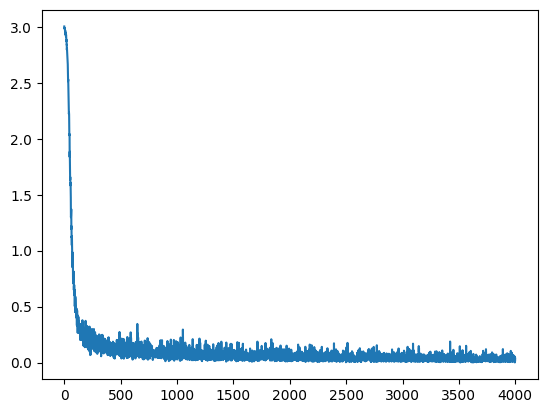

In [7]:
# dodatkowo wyświetlenie wykresu z listą zapisanych strat
import matplotlib.pyplot as plt
plt.plot(losses)

### Testowanie modelu

In [11]:
# wyjświetlenie pierwszych 10 lini dla test_df
test_df.head(n=10)

,Unnamed: 0,labels,text,enc_labels,embeddings
23670,23670,hi,लेकिन मुझे गर ् व है कि उम तुम जानते हो कि मैं...,7,"[0.007848164, -0.0036651262, 0.026494134, -0.0..."
21449,21449,hi,यदि आपके पास improvisation और विस ् तृत आइटेनर...,7,"[-0.010298273, -0.017707799, -0.02271023, -0.0..."
25404,25404,tr,Bireysel suçlular00000000000000000000000000000...,16,"[-0.037312314, 0.017532881, 0.022066459, -0.04..."
25319,25319,en,It's very easy to put on and is comfortable to...,4,"[-0.024336461, 0.00472564, -0.025661621, 0.043..."
20535,20535,pt,Dois surfistas a surfar uma pequena onda.00000...,12,"[-0.03310102, 0.015431527, 0.013763826, -0.039..."
28794,28794,ja,TypeC接続口で、耐久性が良さそうです。外見かっこがよく、充電完了状態もはっきりわかるので...,9,"[0.00017168712, 0.083534606, 0.08145847, 0.032..."
6166,6166,tr,Zengin irlandalı sesi açık : hepsi çok iyi .00...,16,"[-0.05426027, 0.12750795, -0.081845865, 0.0187..."
49266,49266,vi,Để thực hiện một đánh giá đáng tin cậy dữ liệu...,18,"[-0.06975354, 0.081752874, 0.017580966, -0.079..."
25775,25775,nl,Een wit schaap op een helling die naar de came...,10,"[-0.112950735, 0.08583607, 0.01273587, -0.0934..."
16020,16020,pl,Później wypadli z gry i poparli w ostatnich la...,11,"[-0.07266634, 0.0544975, -0.05350853, -0.03557..."


In [12]:
# Utworzenie słownika z istniejących języków i posortowanie go od 0 do 19
lang_dict = sorted(dict(zip(df['enc_labels'], df['labels'])).items())
print(lang_dict)

[(0, 'ar'), (1, 'bg'), (2, 'de'), (3, 'el'), (4, 'en'), (5, 'es'), (6, 'fr'), (7, 'hi'), (8, 'it'), (9, 'ja'), (10, 'nl'), (11, 'pl'), (12, 'pt'), (13, 'ru'), (14, 'sw'), (15, 'th'), (16, 'tr'), (17, 'ur'), (18, 'vi'), (19, 'zh')]


In [16]:
import torch.nn.functional as F

# Przygotowanie danych testowych
test_embeddings = torch.Tensor(np.array(test_df['embeddings'].tolist()))

# Uzyskanie predykcji dla danych testowych
test_pred = model.forward(test_embeddings)

# Przekształcenie wyników predykcji na prawdopodobieństwa przy użyciu funkcji softmax
test_prob = F.softmax(test_pred, dim=1)

# Znalezienie indeksu klasy z najwyższym prawdopodobieństwem dla każdego przykładu
pred_indexes = torch.argmax(test_prob, dim=1)

# Przetłumaczenie indeksów klas na odpowiadające języki
pred_lang = [lang_dict[i.item()] for i in pred_indexes]

In [17]:
tested_df = test_df.copy()

# Dodanie przewidywanych języków do ramki danych testowych
tested_df['predicted_language'] = pred_lang

# Wyświetlenie przewidywanych języków dla danych testowych (30 pierwszych pozycji)
tested_df[['labels', 'predicted_language', 'text']].head(n=30)

,labels,predicted_language,text
23670,hi,"(7, hi)",लेकिन मुझे गर ् व है कि उम तुम जानते हो कि मैं...
21449,hi,"(7, hi)",यदि आपके पास improvisation और विस ् तृत आइटेनर...
25404,tr,"(16, tr)",Bireysel suçlular00000000000000000000000000000...
25319,en,"(4, en)",It's very easy to put on and is comfortable to...
20535,pt,"(12, pt)",Dois surfistas a surfar uma pequena onda.00000...
28794,ja,"(9, ja)",TypeC接続口で、耐久性が良さそうです。外見かっこがよく、充電完了状態もはっきりわかるので...
6166,tr,"(16, tr)",Zengin irlandalı sesi açık : hepsi çok iyi .00...
49266,vi,"(18, vi)",Để thực hiện một đánh giá đáng tin cậy dữ liệu...
25775,nl,"(10, nl)",Een wit schaap op een helling die naar de came...
16020,pl,"(11, pl)",Później wypadli z gry i poparli w ostatnich la...
